## Preprocessing the data

In this notebook we will preprocess our input data in order to ease the main classification task.

In [1]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import shutil 
from tqdm import tqdm

Let's download the dataset:

In [2]:
!pip install kaggle --upgrade

In [3]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

# Enter your kaggle API credentials here!
api_token = {"username":"",
             "key":""}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c platesv2

 91% 43.0M/47.1M [00:00<00:00, 75.5MB/s]
100% 47.1M/47.1M [00:00<00:00, 106MB/s] 
  0% 0.00/8.00k [00:00<?, ?B/s]
100% 8.00k/8.00k [00:00<00:00, 8.40MB/s]


In [5]:
shutil.unpack_archive('plates.zip', '')

Let's take a look on an image from the dataset:

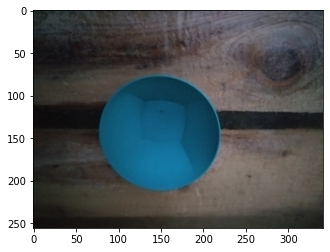

In [15]:
img = cv.imread('plates/test/0324.jpg')
# OpenCV reads images in BGR format for some reason
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB));

So the images include a lot of background, which can be interpreted as dirt (that is, embroil the classification). 

Therefore, we would like to delete it. Fortunately, OpenCV offers a method just for that: [cv.grabCut](https://docs.opencv.org/3.4/d8/d83/tutorial_py_grabcut.html). We set the background to black because black corresponds to zero values in the tensors, which is easier to interpret. Also, more plates are white than black, obviously.

Once we removed the background, we would like to remove the unnecesary black pixels from the image and center the image around the plate. To do that, first we find a centroid of the image using [cv.moments](https://docs.opencv.org/3.4/d0/d49/tutorial_moments.html). 

Our intuition tells us that most of the plates are round, so we look for circles with center close to the centroid ([cv.HoughCircles](https://docs.opencv.org/3.4/da/d53/tutorial_py_houghcircles.html)) and find the one with the biggest radius. For the plates that aren't round, we simply enclose the foreground in a circle with [cv.findContours](https://docs.opencv.org/3.4/d4/d73/tutorial_py_contours_begin.html).

Finally, we enclose the found circle in a square and cut the image outside this square.

The code can be found below (some of it was adapted from [this](https://www.kaggle.com/svyatoslavsokolov/cleaned-vs-dirty/notebook) open notebook).


In [30]:
class Preprocess:
    def __init__(self, img):
        # Convert PIL image to numpy array
        self.img = np.array(img)
        # self.img = cv.cvtColor(self.img, cv.COLOR_BGR2RGB)
        # Get the height and width from OpenCV image
        self.height, self.width = img.shape[:2]
        # Initialize a mask with zeros
        self.mask = np.zeros((self.height, self.width), np.uint8)
        # Initialize the circle enclosing the plate
        self.x_center = 0
        self.y_center = 0
        self.r_circle = 0

    def remove_background(self, offset=15):
        """
        Removes background from a PIL image `img`
        For more info see the documentation of cv.grabCut 
        https://docs.opencv.org/3.4/d8/d83/tutorial_py_grabcut.html

        img - Input image
        mask - It is a mask image where we specify which areas are background, 
        foreground or probable background/foreground etc. 
        It is done by the following flags:
        cv.GC_BGD, cv.GC_FGD, cv.GC_PR_BGD, cv.GC_PR_FGD, or simply pass 0,1,2,3 to image.
        rect - It is the coordinates of a rectangle 
        which includes the foreground object in the format (x,y,w,h)
        bdgModel, fgdModel - These are arrays used by the algorithm internally.
        You just create two np.float64 type zero arrays of size (1,65).
        iterCount - Number of iterations the algorithm should run.
        mode - It should be cv.GC_INIT_WITH_RECT or cv.GC_INIT_WITH_MASK
        or combined which decides whether we are drawing rectangle or final touchup strokes.
        """
            

        # These are arrays used by the algorithm internally.
        # You just create two np.float64 type zero arrays of size (1,65).
        bgdModel = np.zeros((1, 65),np.float64)
        fgdModel = np.zeros((1, 65),np.float64)

        # the coordinates of a rectangle which includes the foreground object in the format (x,y,w,h)
        rect = (offset, offset, self.width - 2*offset, self.height - 2*offset)
        # rect = (15, 15, self.width-30, self.height-30)
        # rect = (0, 0, self.width, self.height)
        cv.grabCut(self.img, self.mask, rect, bgdModel, fgdModel, 10, cv.GC_INIT_WITH_RECT)
        # zeros in the mask are classified as the background
        # ones are classified as the foreground
        # twos are classified as probable background
        # threes are classified as probable foreground
        self.mask = np.where((self.mask==2)|(self.mask==0), 0, 1).astype('uint8')
        self.img = self.img * self.mask[:, :, np.newaxis]


    def remove_background_two_step(self, margin=0.08, center_size=0.01):
        """
        A modified version of the previous method
        with two-step background-foreground separation
        """
        # cut margin from each side
        bg_w = round(self.width * margin)
        bg_h = round(self.height * margin)
        # The rectangle that should contain the foreground in the format (x, y, w, h)
        fg_rect = (bg_w, bg_h, self.width - bg_w, self.height - bg_h)

        # The rectangle containing the center 1% of the image
        center_w = round(self.width * (1 - center_size) / 2)
        center_h = round(self.height * (1 - center_size) / 2)
        center_rect = (center_w, center_h, self.width - center_w, self.height - center_h)
        # Mark this rectangle as the foreground
        cv.rectangle(self.mask, center_rect[:2], center_rect[2:4], color=cv.GC_FGD, thickness=-1)

        # Make a first run of the separation initializing with rectangle
        bgdModel1 = np.zeros((1, 65), np.float64)
        fgdModel1 = np.zeros((1, 65), np.float64)
        cv.grabCut(self.img, self.mask, fg_rect, bgdModel1, fgdModel1, 3, cv.GC_INIT_WITH_RECT)

        # Mark a mask area as probable background
        # and separate another time initializing with mask
        cv.rectangle(self.mask, fg_rect[:2], fg_rect[2:4], color=cv.GC_PR_BGD, thickness=bg_w * 3)
        cv.grabCut(self.img, self.mask, fg_rect, bgdModel1, fgdModel1, 10, cv.GC_INIT_WITH_MASK)   

        self.mask = np.where((self.mask==2)|(self.mask==0), 0, 1).astype('uint8')
        self.img = self.img * self.mask[:, :, np.newaxis]

    def find_center(self):
        """Find the centroid of the foreground"""
        M_mask = cv.moments(self.mask)
        self.x_center = int(M_mask['m10'] / M_mask['m00'])
        self.y_center = int(M_mask['m01'] / M_mask['m00'])

    def find_circle(self):
        """Find the maximal circle on the foreground"""
        self.find_center()
        # Convert to grayscale to find circles
        img_gray = cv.cvtColor(cv.convertScaleAbs(self.img, alpha=1.2), cv.COLOR_BGR2GRAY)
        circles = cv.HoughCircles(img_gray, cv.HOUGH_GRADIENT, 1, 10, param1=10, param2=5, minRadius=40, maxRadius=250)
        circles = circles[0, :]

        # Look for circles with center close to the current centroid
        # and find the one with maximal radius
        for x, y, r in circles:
            if ((self.x_center - 15) < x < (self.x_center + 15)) and ((self.y_center - 15 ) < y < (self.y_center + 15)):
                if r > self.r_circle:
                    self.x_cetner = x
                    self.y_center = y
                    self.r_circle = r

        # If no circles were found, enclose the foreground in a circle
        if self.r_circle == 0:
            contours, hierarchy = cv.findContours(self.mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_TC89_KCOS)
            max_contour = max(contours, key=cv.contourArea)
            (self.x_center, self.y_center), self.r_circle = cv.minEnclosingCircle(c)

    def crop_circle(self, expansion_factor=1.2):
        """Crop the image around the maximal circle"""
        self.find_circle()
        
        # make a square around the circle and crop around it
        x_min = int(max(self.x_center - expansion_factor*self.r_circle, 0))
        x_max = int(min(self.x_center + expansion_factor*self.r_circle, self.width))
        y_min = int(max(self.y_center - expansion_factor*self.r_circle, 0))
        y_max = int(min(self.y_center + expansion_factor*self.r_circle, self.height))
        # print(y_min, y_max, x_min, x_max)

        self.img = self.img[y_min:y_max, x_min:x_max]

Let's apply the two foreground extraction method to our sample image:

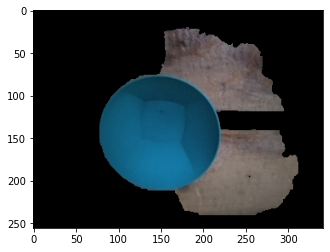

In [16]:
img_cleaned = Preprocess(img)
img_cleaned.remove_background()
plt.imshow(cv.cvtColor(img_cleaned.img, cv.COLOR_BGR2RGB));

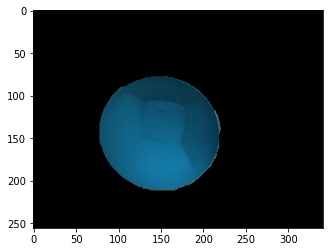

In [17]:
img_cleaned = Preprocess(img)
img_cleaned.remove_background_two_step()
plt.imshow(cv.cvtColor(img_cleaned.img, cv.COLOR_BGR2RGB));

The second one worked better.
Generally, we found that the `remove_background_two_step` method is generally more "aggressive" and better extracts the plate image against a wooden background, although it's sometimes too strict and deletes a part of the plate too or fails when the background's color is similar to the plate's:

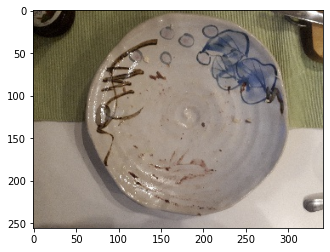

In [25]:
img = cv.imread('plates/test/0084.jpg')
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB));

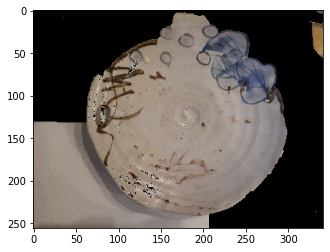

In [27]:
img_cleaned = Preprocess(img)
img_cleaned.remove_background_two_step()
plt.imshow(cv.cvtColor(img_cleaned.img, cv.COLOR_BGR2RGB));

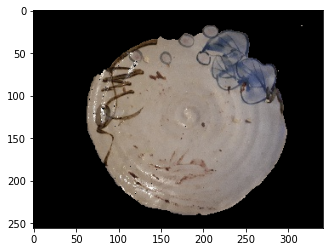

In [28]:
img_cleaned = Preprocess(img)
img_cleaned.remove_background()
plt.imshow(cv.cvtColor(img_cleaned.img, cv.COLOR_BGR2RGB));

We should note that the `cv.grabCut` algorithm is stochastic, so it may produce slightly different results each time.

Now let's check how the centering works:

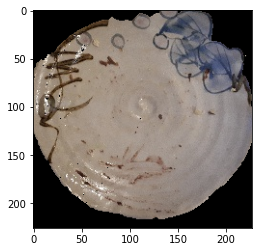

In [29]:
img_cleaned.crop_circle()
plt.imshow(cv.cvtColor(img_cleaned.img, cv.COLOR_BGR2RGB));

Looks good.

Now let's preprocess all images in the dataset.
The images in the `plates_preprocessed.zip` file in the project folder were handpicked from two runs of the below function (first with `remove_background` method, second with `remove_background_two_step` method) — this is feasible because the dataset isn't that large. However, a single run with either option produces decent results.

In [38]:
def preprocess_images(image_folder):
    """
    Preprocess all images in a given folder:
    remove backgrounds and cut around the maximal circle
    """
    files = os.listdir(image_folder)
    imgs = [file_ for file_ in files if file_.endswith('.jpg')]
        
    for img in tqdm(imgs):
        img_original = cv.imread(os.path.join(image_folder, img))
        img_cleaned = Preprocess(img_original)
        # img_cleaned.remove_backgroud()
        img_cleaned.remove_background_two_step()
        img_cleaned.crop_circle()
        cv.imwrite(os.path.join(image_folder, img), img_cleaned.img)

In [39]:
preprocess_images('plates/train/dirty')

100%|██████████| 20/20 [01:02<00:00,  3.14s/it]


In [40]:
preprocess_images('plates/train/cleaned')

100%|██████████| 20/20 [00:58<00:00,  2.95s/it]


In [41]:
preprocess_images('plates/test')

100%|██████████| 744/744 [36:53<00:00,  2.98s/it]


In [42]:
shutil.make_archive('plates_preprocessed', 'zip', 'plates')

'/content/plates_preprocessed.zip'